In [ ]:
!pip install rasterio

In [ ]:
import tensorflow as tf
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import time
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def get_model():
  '''
  This function gets the model from the drive

  Returns
  - model (tf.keras.Model): the model
  - new_model (str): the path to the model
  '''
  while True:
    new_model = str(input('Please enter the model you want to use - ')).strip()
    if os.path.exists(new_model):
      # if a model exists, load it.
      model = tf.keras.models.load_model(new_model)
      print(f'Model {new_model.split("/")[-1]} loaded successfully.')
      break
    else:
      print('\033[1mModel not found. Please try again.\033[0m')
      print()
  return model, new_model

In [ ]:
def check_if_tiff_file(path):
  '''
  This function checks if the file is a tiff file

  Args:
  - path (str): the path to the file

  Returns
  - True if the file is a tiff file, False otherwise
  '''
  return path.endswith('.tif')

In [ ]:
def get_raster_image():
  '''
  This function gets the base directory from the user

  Returns
  - BASE_DIR (str): the base directory
  '''
  while True:
    new_raster_name = str(input('Please enter the tif file - '))
    if os.path.exists(new_raster_name):
      if check_if_tiff_file(new_raster_name):
        print(f'Raster {new_raster_name.split("/")[-1]} will be used for prediction.')
        break
      else:
        print('\033[1mPlease enter a tif file.\033[0m')
        print()
    else:
      print('\033[1mRaster not found. Please try again.\033[0m')
      print()
  return new_raster_name

In [ ]:
def get_output_directory():
  '''
  This function gets the output directory from the user

  Returns
  - output_dir (str): the output directory
  '''
  x_variable = True    # Variable for the outer loop
  while x_variable:
    # Getting the input for the directory name
    output_dir = str(input('Please enter the output directory - ')).strip()

    # Checking if the path exists or not
    if os.path.exists(output_dir):
      # If the directory exists, use it
      print(f'Output directory {output_dir.split("/")[-1]} will be used for prediction.')
      break
    elif not os.path.exists(output_dir):
      # If the path doesnot exists, ask if user wants to create it
      print('\033[1mOutput directory not found. Follow the instructions below.\033[0m')
      print()
      while True:
        new_directory = str(input('Output directory not found. Would you like to create it? (y/n) - ')).strip().lower()
        if new_directory == 'y':
          # If the user wants to create the directory, create it
          os.makedirs(output_dir, exist_ok=True)
          x_variable = False
          # If user does not wants to create it.
          print(f'Output directory {output_dir.split("/")[-1]} created successfully.')
          break
        elif new_directory == 'n':
          # If the user doesnot wants to create a new directory
          print('\033[1mPlease try again.\033[0m')
          print()
          break
        else:
          # If the input is not of given value.
          print('\033[1mPlease enter y or n.\033[0m')
          print()
  return output_dir

In [ ]:
def confirm_inputs(model_path, output_dir, raster_img):
  '''
  This function confirms the inputs from the user

  Parameters:
  - model_path (str): the model path
  - output_dir (str): the output directory
  - raster_img (str): the raster image

  Returns
  - True if the inputs are confirmed, False otherwise
  '''
  print(f'\033[1mThe model path is -\033[0m {model_path}.')
  print(f'\033[1mThe output directory is -\033[0m {output_dir}.')
  print(f'\033[1mThe raster image is -\033[0m {raster_img}.')
  print()

  while True:
    confirm_input = str(input('Please confirm the inputs (y/n) - ')).strip().lower()
    if confirm_input == 'y':
      print('\033[1mInputs confirmed.\033[0m')
      return True
    elif confirm_input == 'n':
      return False
    else:
      print('\033[1mPlease enter y or n.\033[0m')
      print()

In [ ]:
def convert_to_int(img):
  '''
  This function converts the image to int.
  The value is converted to its floor value.
  An example - 0.7 will be converted to 0.

  Parameters
  - img (np.array): the image

  Returns
  - output_data (np.array): the image
  '''
  # Lookup table for the values ranging from 0 to 100
  lookup_table = np.arange(101)

  # applying the lookup table
  mapped_table = lookup_table[np.floor(img).astype(int)]
  output_data = mapped_table.astype(np.uint8)
  return output_data

In [ ]:
def create_plot(img_path):
  '''
  This function creates a plot of the image

  Parameters
  - img_path (str): the image path
  '''
  img_raster = rasterio.open(img_path)
  img = img_raster.read([1])
  img_transpose = img.transpose(1, 2, 0)
  plt.figure(figsize=(10, 10))
  plt.title('Prediction Image')
  plt.imshow(img_transpose)
  plt.show()

  del img_raster
  del img
  del img_transpose

In [ ]:
def predict_model(img, prediction_model, height, width, tile_size=246):
  '''
  This function predicts the image using the model.

  Parameters
  - img (np.array): the image
  - prediction_model (tf.keras.Model): the prediction model
  - height (int): the height of the image
  - width (int): the width of the image
  - tile_size (int): the tile size

  Returns
  - horizontal_layer (np.array): the predicted image
  '''
  # Splitting the image into tiles
  num_tiles_x =  width // tile_size
  num_tiles_y = height // tile_size

  # This list will contain the whole predicted tile
  horizontal_layer = []

  # Predicting the tiles
  for tile_x in range(num_tiles_x + 1):
    vertical_layer = []
    for tile_y in range(num_tiles_y + 1):
      # Getting the smaller tiles for prediction
      left = tile_x * tile_size
      top = tile_y * tile_size
      right = min(width, left + tile_size)
      bottom = min(height, top + tile_size)

      print(f'Left - {left}, Top - {top}, Right - {right}, Bottom - {bottom}')

      # Updating the window
      window = Window(left, top, right - left, bottom - top)

      # Smaller tile from the bigger tile
      inter_tile = img[:4, top:bottom, left:right]
      inter_tile = np.nan_to_num(inter_tile, nan=0)

      feature_tile = np.expand_dims(inter_tile.transpose(1, 2, 0), axis=0)

      # Desire size after padding
      desired_size = (tile_size + 10, tile_size + 10)

      # Calculate the required padding on each side
      padding_rows = max(0, desired_size[0] - inter_tile.shape[1])
      padding_cols = max(0, desired_size[1] - inter_tile.shape[2])

      # Pad the image
      pad_top = padding_rows // 2
      pad_bottom = padding_rows - pad_top
      pad_left = padding_cols // 2
      pad_right = padding_cols - pad_left

      padded_image = np.pad(feature_tile, ((0, 0), (pad_top, pad_bottom),
                            (pad_left, pad_right), (0, 0)), mode='reflect')

      # Predicting the tile
      pred_tile = prediction_model.predict(padded_image)[0].transpose(2, 0, 1)

      # This is the original size of the tile
      original_size = (tile_size, tile_size)

      # Calculate the amount of padding on each side
      padding_rows = pred_tile.shape[1] - original_size[0]
      padding_cols = pred_tile.shape[2] - original_size[1]

      # Calculate the cropping indices
      crop_top = padding_rows // 2
      crop_bottom = crop_top + original_size[0]
      crop_left = padding_cols // 2
      crop_right = crop_left + original_size[1]

      # Crop the padded image to the original size
      restored_image = pred_tile[:, crop_top:crop_bottom, crop_left:crop_right]

      # Deleting the temporary variables
      del feature_tile
      del padded_image
      del pred_tile
      del padding_rows
      del padding_cols
      del crop_top
      del crop_bottom
      del crop_left
      del crop_right

      # This is the vertical image layer by layer
      if vertical_layer == []:
        vertical_layer = restored_image
      else:
        vertical_layer = np.concatenate((vertical_layer, restored_image),1)

    # This is the horizonal image layer by layer
    if horizontal_layer == []:
      horizontal_layer = vertical_layer
    else:
      horizontal_layer = np.concatenate((horizontal_layer, vertical_layer),2)

    del vertical_layer

  return horizontal_layer*100

Get the model for prediction

**If there is no need to change the model, you can run this cell only once.**

In [ ]:
model, model_path = get_model()

Please enter the model you want to use - /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Models/Second_Adam_MeanSquaredError_Google
Model Second_Adam_MeanSquaredError_Google loaded successfully.


Get the output directory

**If the output directory is same every time, you can run this cell only once.**

In [ ]:
output_dir = get_output_directory()

Please enter the output directory - /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Raj_Sentinel_Pipeline_Experimental
Output directory Raj_Sentinel_Pipeline_Experimental will be used for prediction.


Get the raster on which prediction needs to be done

In [ ]:
raster_img = get_raster_image()

Please enter the tif file - /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Raj_Rwanda_Whole_Country_Prediction/Rwanda_Country-0000018944-0000018944.tif
Raster Rwanda_Country-0000018944-0000018944.tif will be used for prediction.


In [ ]:
while True:
  try:
    if model is not None and output_dir is not None and raster_img is not None:
      print('None of the input is empty. Please continue.')
      break
    else:
      print('\033[1mPlease enter all the inputs.\033[0m')
      print('This loop will go on forever. Break this loop and enter the values.')
    time.sleep(30)
  except KeyboardInterrupt:
    print('\033[1mStopped this loop. Make sure that nothing is left.\033[0m')


None of the input is empty. Please continue.


In [ ]:
ask_question = True
while True:
  if ask_question:
    if confirm_inputs(model_path, output_dir, raster_img):
      break
    else:
      ask_question = False
  else:
    print()
    print('\033[1mPlease enter the inputs again.\033[0m')
    print('This loop will go on forever. Break this loop and enter the values.')

  time.sleep(30)


The model path is - /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Models/Second_Adam_MeanSquaredError_Google.
The output directory is - /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Raj_Sentinel_Pipeline_Experimental.
The raster image is - /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Raj_Rwanda_Whole_Country_Prediction/Rwanda_Country-0000018944-0000018944.tif.

Please confirm the inputs (y/n) - 
Please enter y or n.

Please confirm the inputs (y/n) - y
Inputs confirmed.


Plotting the image that needs to be predicted

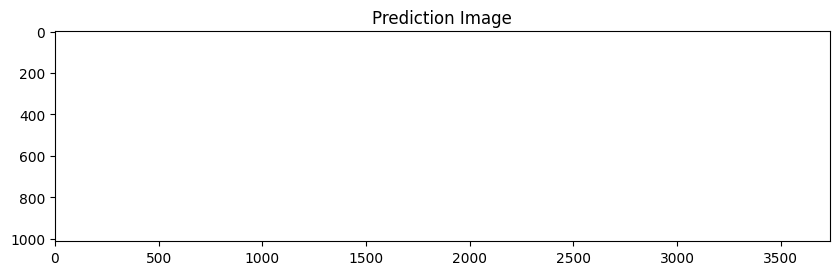

In [ ]:
create_plot(raster_img)

Applying the model on the image.

**The name of the output predicted image will be {raster_name}_predicted_integer.tif**

Predicting the image Rwanda_Country-0000018944-0000018944
Left - 0, Top - 0, Right - 246, Bottom - 246
1/1 [==============================] - 0s 215ms/step
Left - 0, Top - 246, Right - 246, Bottom - 492
1/1 [==============================] - 0s 221ms/step
Left - 0, Top - 492, Right - 246, Bottom - 738


<ipython-input-25-84e6de67b898>:90: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if vertical_layer == []:


1/1 [==============================] - 0s 227ms/step
Left - 0, Top - 738, Right - 246, Bottom - 984
1/1 [==============================] - 0s 219ms/step
Left - 0, Top - 984, Right - 246, Bottom - 1012
1/1 [==============================] - 0s 219ms/step
Left - 246, Top - 0, Right - 492, Bottom - 246
1/1 [==============================] - 0s 215ms/step
Left - 246, Top - 246, Right - 492, Bottom - 492
1/1 [==============================] - 0s 219ms/step
Left - 246, Top - 492, Right - 492, Bottom - 738
1/1 [==============================] - 0s 222ms/step
Left - 246, Top - 738, Right - 492, Bottom - 984
1/1 [==============================] - 0s 223ms/step
Left - 246, Top - 984, Right - 492, Bottom - 1012
1/1 [==============================] - 0s 214ms/step
Left - 492, Top - 0, Right - 738, Bottom - 246


<ipython-input-25-84e6de67b898>:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if horizontal_layer == []:


1/1 [==============================] - 0s 215ms/step
Left - 492, Top - 246, Right - 738, Bottom - 492
1/1 [==============================] - 0s 225ms/step
Left - 492, Top - 492, Right - 738, Bottom - 738
1/1 [==============================] - 0s 212ms/step
Left - 492, Top - 738, Right - 738, Bottom - 984
1/1 [==============================] - 0s 216ms/step
Left - 492, Top - 984, Right - 738, Bottom - 1012
1/1 [==============================] - 0s 215ms/step
Left - 738, Top - 0, Right - 984, Bottom - 246
1/1 [==============================] - 0s 203ms/step
Left - 738, Top - 246, Right - 984, Bottom - 492
1/1 [==============================] - 0s 218ms/step
Left - 738, Top - 492, Right - 984, Bottom - 738
1/1 [==============================] - 0s 212ms/step
Left - 738, Top - 738, Right - 984, Bottom - 984
1/1 [==============================] - 0s 223ms/step
Left - 738, Top - 984, Right - 984, Bottom - 1012
1/1 [==============================] - 0s 216ms/step
Left - 984, Top - 0, Right - 

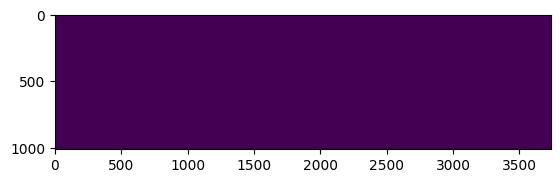

Predicted image saved at /content/drive/MyDrive/Raj_RGB_Data/Raj_Rwanda_RGB_Data/Raj_Sentinel_Pipeline_Experimental/Rwanda_Country-0000018944-0000018944_predicted_integer.tif


In [ ]:
file_name = raster_img.split('/')[-1].split('.')[0]
print(f'Predicting the image {file_name}')

# Opening the image
img_raster = rasterio.open(raster_img)
profile = img_raster.profile

# Getting the height and width of the image
height = profile['height']
width = profile['width']

# Reading the image
img = img_raster.read([1, 2, 3])

# Getting the predicted image
horizontal_layer = predict_model(img, model, height, width)

# Cropping to proper size
final_layer = horizontal_layer[:, :height, :width]

# Convert the file to integer
integer_img = convert_to_int(final_layer)

# Plotting the image
plt.imshow(integer_img.transpose(1,2,0))
plt.show()

# Updating the profile
profile.update(count=1)

# Get the output file name
output_file_name = file_name + '_predicted_integer.tif'
output_file_path = os.path.join(output_dir, output_file_name)

# Saving the image
with rasterio.open(output_file_path, 'w', **profile) as dst:
  dst.write(integer_img)

del img
del horizontal_layer
del final_layer
del integer_img

print(f'Predicted image saved at {output_file_path}')